# Chronological Attribution of ancient texts using deep NNs

In [1]:
import pandas as pd
import numpy as np
import sys

import matplotlib.pyplot as plt
import data_explore
import utils

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow as tf

import keras
from keras.optimizers import SGD

import torch
import torch.nn as nn


from datetime import datetime
from time import time

import warnings
warnings.filterwarnings("ignore")



In [2]:
# Start time of Execution
time_start = time()

### Data Exploration & Preprocessing

In [3]:
# Retrieve data in DataFrame format
data = pd.read_csv('iphi2802.csv', sep= '\t')
df = pd.DataFrame(data)
df = df.drop(columns=['id', 'metadata', 'date_str', 'date_circa', 'region_main', 'region_sub'])

#### Exploratory Data Analysis

In [4]:
df.head()

,text,region_main_id,region_sub_id,date_min,date_max
0,[φ]ιλεταιρος ευμενου περγαμευς μουσαις. καφισι...,1698,1691,-275.0,-226.0
1,μαλκοιδων ηρωνος.,1699,474,1.0,300.0
2,βασιλικος.,1692,1485,-300.0,-101.0
3,αισκλαπιει μ [ανεθεκε --].,1690,1643,-600.0,-401.0
4,[---]ος αν[εθηκε δαματρι].,1696,1689,-350.0,-251.0


In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2802 entries, 0 to 2801
Data columns (total 5 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   text            2802 non-null   object 
 1   region_main_id  2802 non-null   int64  
 2   region_sub_id   2802 non-null   int64  
 3   date_min        2802 non-null   float64
 4   date_max        2802 non-null   float64
dtypes: float64(2), int64(2), object(1)
memory usage: 109.6+ KB


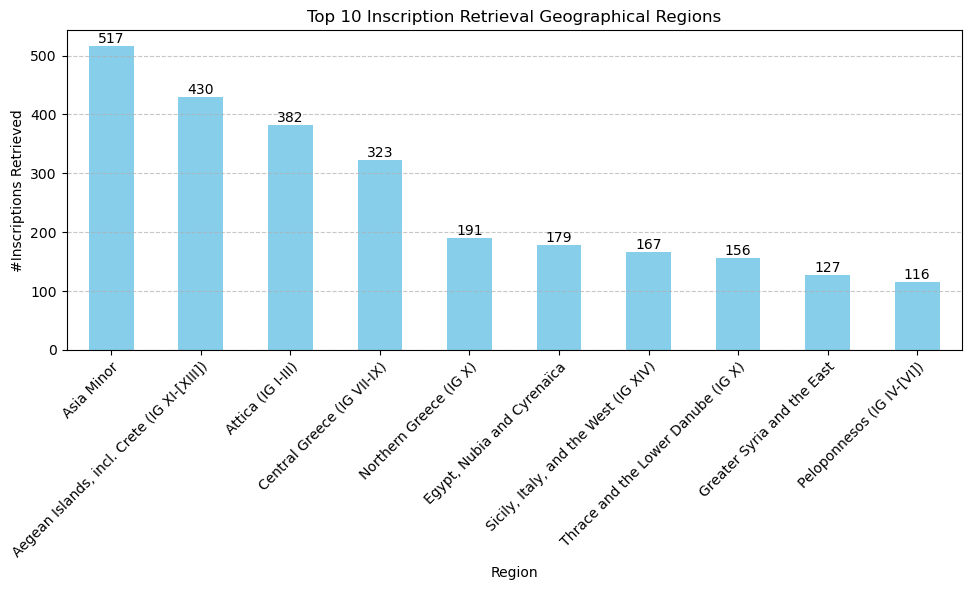

In [11]:
# Locations' dictionaries
region_main_dict = {key: value for key, value in zip(df['region_main_id'], df['region_main'])}
region_sub_dict = {key: value for key, value in zip(df['region_sub_id'], df['region_sub'])}
region_dict = {
    'region_main_dict': region_main_dict,
    'region_sub_dict': region_sub_dict
}
# Plot epigraph location frequency histogram
plt.figure(figsize=(10, 6))
bars = df['region_main_id'].value_counts().head(10).plot(kind='bar', color='skyblue')
plt.title('Top 10 Inscription Retrieval Geographical Regions')
plt.xlabel('Region')
plt.ylabel('#Inscriptions Retrieved')
plt.xticks(range(len(df['region_main_id'].value_counts().head(10))), [region_main_dict[key] for key in df['region_main_id'].value_counts().head(10).index], rotation=45, ha='right', rotation_mode='anchor')
plt.grid(axis='y', linestyle='--', alpha=0.7)

for bar in bars.patches:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), str(int(bar.get_height())), ha='center', va='bottom')

plt.tight_layout()

plt.show()

#### Data Preprocessing - Text Encoding (Tokenization/Vectorization) / Scaling

In [6]:
# extracting features - predictors
text = df['text'].tolist()
region_main = df['region_main_id']
region_sub = df['region_sub_id']
# extracting labels
date_min  = df['date_min'].tolist()
date_max = df['date_max'].tolist()

# for usage on determing the features' selection in vectorization using ANOVA
df = df.assign(date_mean=(df['date_min'] + df['date_max']) / 2)
date_mean = df['date_mean']

labels_df = pd.DataFrame({
    'date_min': date_min,
    'date_max': date_max
})

Average number of words per sample: 7.0
Total number of ngrams: 81315


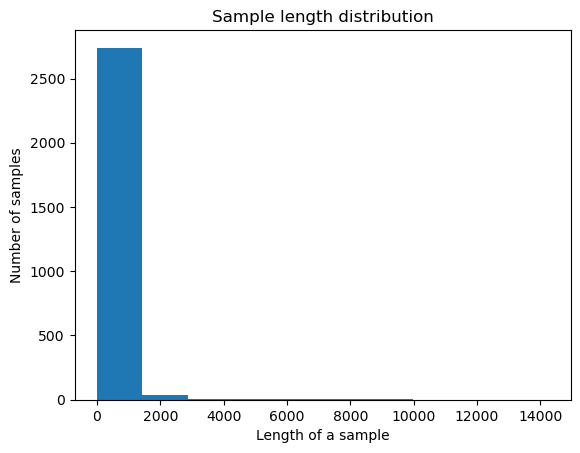

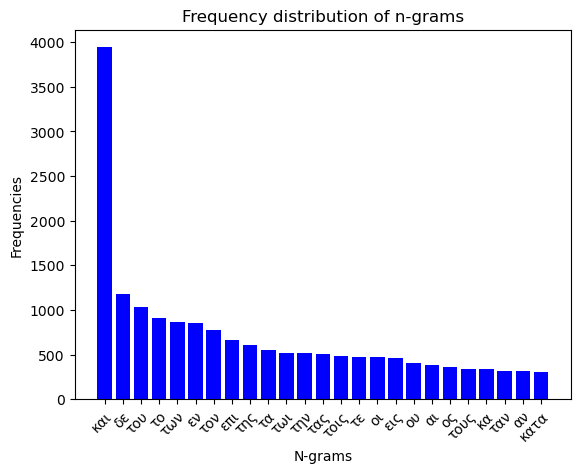

In [7]:
ave, ngrams = data_explore.get_num_words_per_sample(text)
print(f'Average number of words per sample: {ave}')
print(f'Total number of ngrams: {ngrams}')

# plot sample length distribution
data_explore.plot_sample_length_distribution(text)

# plot frequency distribution of ngrams
data_explore.plot_frequency_distribution_of_ngrams(text)

In [8]:
print(f'Total Samples / Average Number of Words per Sample = {2802/ave:.2f}')

Total Samples / Average Number of Words per Sample = 400.29


In [9]:
# Split data
X_train, X_test, labels_train, labels_test = train_test_split(text, labels_df, test_size=.3, random_state=42) 

In [10]:
# Text vectorization
X_train_vect, X_test_vect = utils.ngram_vectorize(X_train, X_test)


Tokens[:40]: ['αα' 'αγ' 'αγα' 'αγαθ' 'αγαθα' 'αγαθαι' 'αγαθαι τυχαι' 'αγαθει'
 'αγαθει τυχει' 'αγαθη' 'αγαθη τυχη' 'αγαθηι' 'αγαθηι τυχηι' 'αγαθοκλης'
 'αγαθον' 'αγαθος' 'αγαθους' 'αγαθων' 'αγαλμα' 'αγησαρχου'
 'αγησαρχου δελφου' 'αγια' 'αγιου' 'αγω' 'αγων' 'αγωνα' 'αγωνι'
 'αγωνοθετην' 'αγωνος' 'αδ' 'αδελφον' 'αδελφω' 'αδριανος'
 'αδριανος σεβαστος' 'αδριανου' 'αδριανω' 'αει' 'αθ' 'αθανα' 'αθαναι']

Number of tokens: 2000

Stop words: None


In [11]:
print(f'Train Set size: {X_train_vect.shape}, Test Set size: {X_test_vect.shape}')

Train Set size: (1961, 2000), Test Set size: (841, 2000)


### Scaling

In [12]:
# Scaling labels
scaler = MaxAbsScaler()

# Fit scaler to new_df
scaler.fit(labels_train)

# Transform new_df using the scaler
scaled_labels_train = scaler.transform(labels_train)
scaled_labels_test = scaler.transform(labels_test)

In [13]:
scaled_labels_train.shape

(1961, 2)

# Neural Network

In [14]:
# Custom RMSE function
def rmse_custom(y_true, y_pred):
    e = tf.where(
        y_pred[:, 0] < y_true[:, 0],
        y_true[:, 0] - y_pred[:, 0],
        tf.where(
            y_pred[:, 1] > y_true[:, 1],
            y_pred[:, 1] - y_true[:, 1],
            tf.zeros_like(y_pred[:, 0])
        )
    )
    return tf.sqrt(tf.reduce_mean(tf.square(e)))

13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 294us/step - loss: 0.0015   
Fold: 1, Validation RMSE: 0.005
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 373us/step - loss: 0.0038
Fold: 2, Validation RMSE: 0.009
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 357us/step - loss: 0.0045   
Fold: 3, Validation RMSE: 0.009
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 343us/step - loss: 0.0125   
Fold: 4, Validation RMSE: 0.013
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 296us/step - loss: 0.0079
Fold: 5, Validation RMSE: 0.006


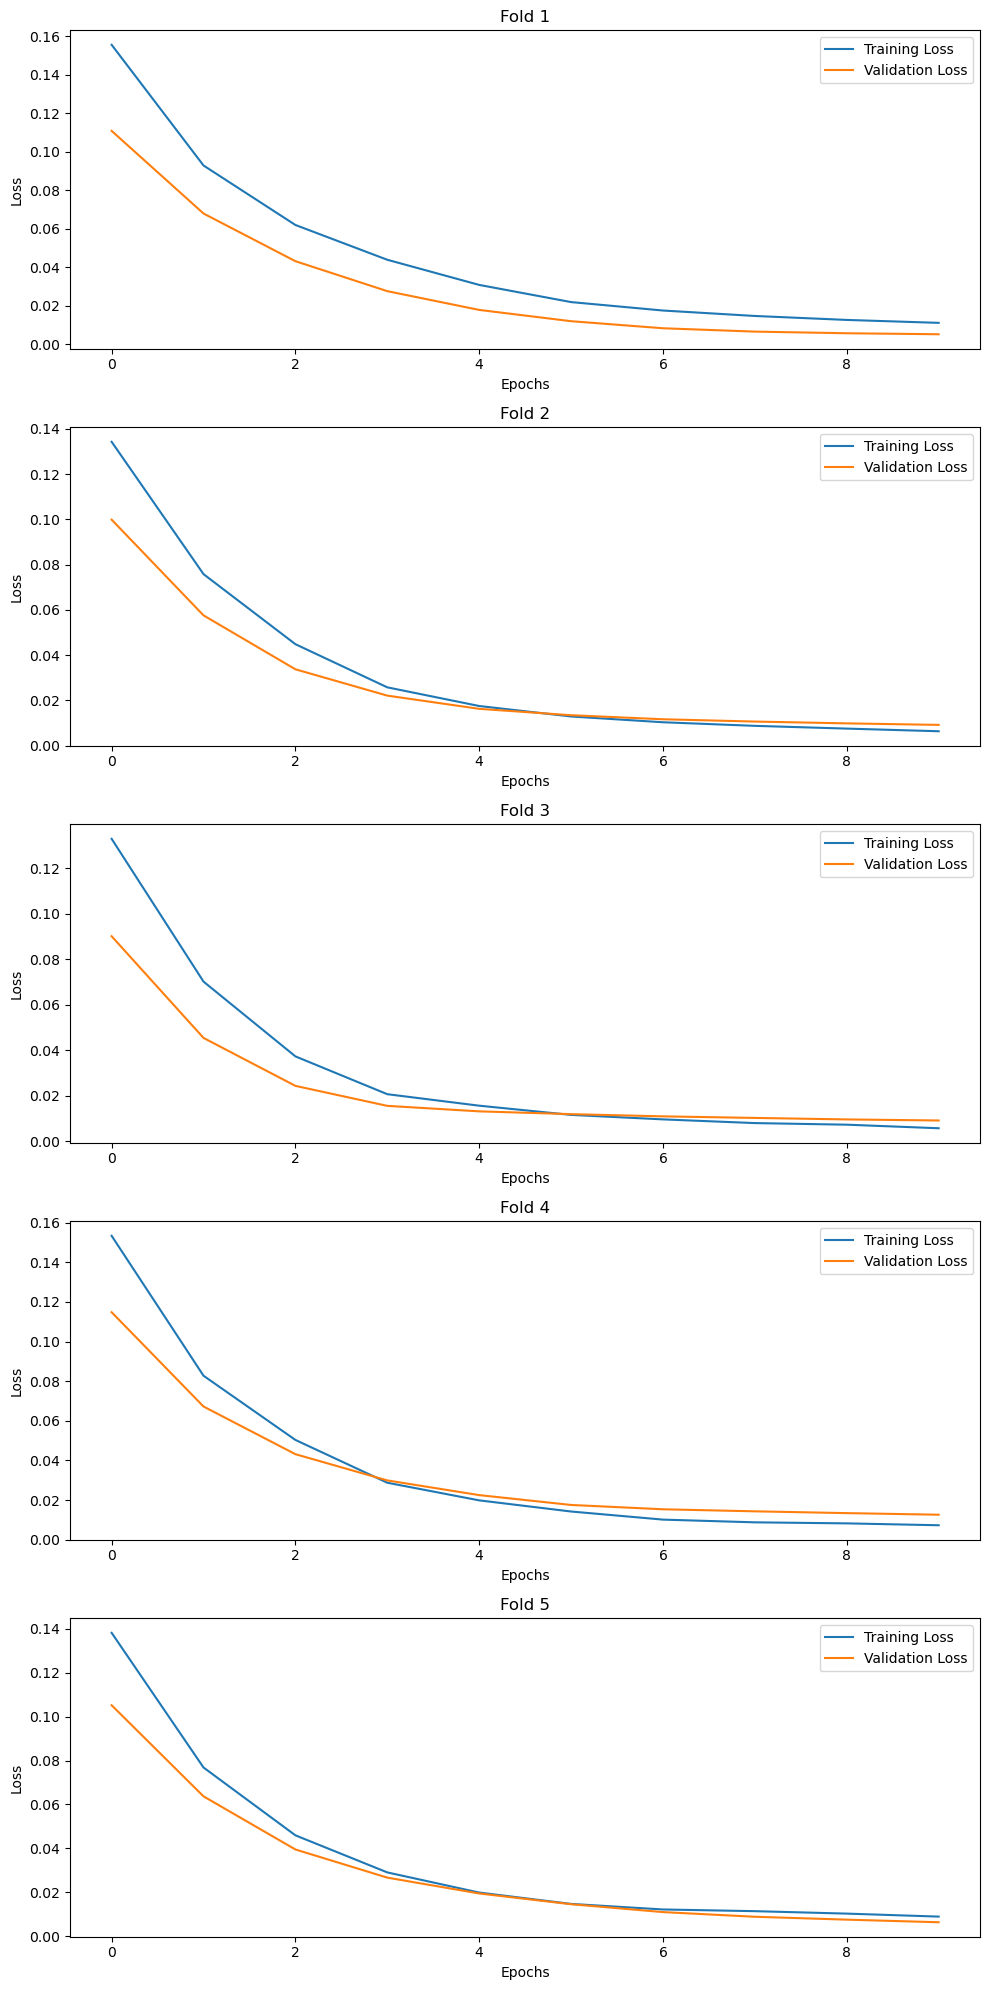

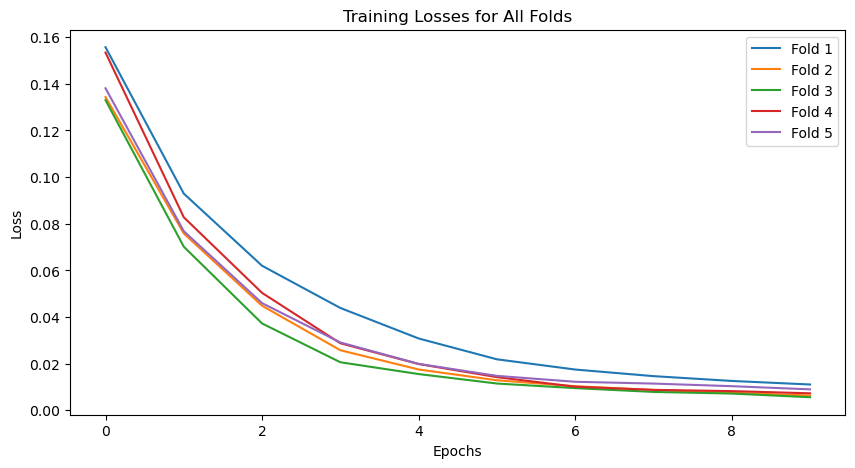

Model: "sequential_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_8 (Dense)                 │ (None, 64)             │       128,064 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 2)              │           130 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 128,196 (500.77 KB)

 Trainable params: 128,194 (500.76 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

In [15]:
# 5-Fold Cross Validation performing on the training set
rmseTrain = []
rmseValidation = []

kfold = KFold(n_splits=5, shuffle=True, random_state=42)

fig, axs = plt.subplots(5, figsize=(10, 20))

for i, (train, test) in enumerate(kfold.split(X_train_vect)):
    X_train_fold, X_test_fold = X_train_vect[train], X_train_vect[test]
    y_train_fold, y_test_fold = scaled_labels_train[train], scaled_labels_train[test]

    # Define the model
    model = Sequential()
    model.add(Dense(64, input_dim=X_train_vect.shape[1], activation='relu'))
    model.add(Dense(2, activation='linear'))

    # Compile the model with SGD optimizer
    optimizer = SGD(learning_rate=0.005, momentum=0.0, nesterov=False)
    model.compile(loss=rmse_custom, optimizer=optimizer)

    # Fit the model
    history = model.fit(X_train_fold,
                        y_train_fold,
                        validation_data=(X_test_fold, y_test_fold),
                        epochs=10, 
                        batch_size=32, 
                        verbose=0)

    # Plot the loss
    axs[i].plot(history.history['loss'], label='Training Loss')
    axs[i].plot(history.history['val_loss'], label='Validation Loss')
    axs[i].set_title(f'Fold {i+1}')
    axs[i].set_xlabel('Epochs')
    axs[i].set_ylabel('Loss')
    axs[i].legend()
    
    # Evaluate the model
    scores = model.evaluate(X_test_fold, y_test_fold)
    rmseValidation.append(scores)
    print(f'Fold: {i+1}, Validation RMSE: {scores:.3f}')

    # Store training loss
    rmseTrain.append(history.history['loss'])
    rmseValidation.append(history.history['val_loss']) 

plt.tight_layout()
plt.show()

# Plot all training losses
plt.figure(figsize=(10, 5))
for i in range(len(rmseTrain)):
    plt.plot(rmseTrain[i], label=f'Fold {i+1}')
plt.title('Training Losses for All Folds')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

model.summary()


In [19]:
prediction = model.predict(X_test_vect[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step


In [35]:
rmse = rmse_custom(prediction, scaled_labels_test[0].reshape(1, -1))

In [56]:
X_test_vect[0].shape, scaled_labels_test[0].shape

((1, 2000), (2,))

In [59]:
model.predict(X_test_vect[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


array([[ 0.54079664, -0.4186358 ]], dtype=float32)

In [68]:
scaled_labels_test[0].shape,  prediction.shape

((2,), (1, 2))

In [73]:
# Calculating the RMSE for all the samples in test set and plot the RMSE values
yhat = []
rmse1 = []
sum = 0

# Iterate through the test set using enumerate to get both index and value
for i in range(X_test_vect.shape[0]):
    # Predict the value for the current test sample
    X_test_ve = X_test_vect.toarray()
    X_test, y_test =X_test_ve[i], scaled_labels_test[i]

    prediction = model.predict(X_test)
    # Define the lambda function
    rmse__ = lambda y_true, y_pred: np.sqrt(np.mean((y_true.reshape(-1) - y_pred.reshape(-1))**2))

    scores1 = rmse__(y_test.reshape(-1, 1), prediction.reshape(-1, 1))
    
    rmse1.append(scores1)
    
    print(f'Sample: {i+1}, Test RMSE: {scores1:.3f}')
    
    # Append the predicted value to the yhat list
    # yhat.append(prediction[0])
    
    # loss = rmse_custom(scaled_labels_test[i].reshape(1, -1), prediction)
    # RMSE.append(loss)
    sum += scores1
    
rmse_m = sum / X_test_vect.shape[0]
print(f'Mean RMSE: {rmse_m}')

# Plotting the RMSE values
plt.figure(figsize=(10, 6))
plt.plot(rmse1)
plt.xlabel('Sample Index')
plt.ylabel('RMSE')
plt.title('RMSE on Test Set')
plt.show()

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(32,), dtype=float32). Expected shape (None, 2000), but input has incompatible shape (32,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(32,), dtype=float32)
  • training=False
  • mask=None

### 5-F CV ANN(623, 64, 1) using date_mean as target variable

In [16]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold
from keras.models import Sequential
from keras.layers import Dense
from sklearn.metrics import mean_squared_error

# Define the number of folds
num_folds = 5

# Define the input dimensions
input_dim = 623

# Define the number of units in the hidden layer
hidden_units = 64

# Define the number of epochs and batch size
epochs = 50
batch_size = 20

# Define lists to store the MSE scores for each fold
rmse_scores = []
loss_per_fold = []

# Define the KFold cross-validator
kf = KFold(n_splits=num_folds, shuffle=True)

# Define lists to store training and validation loss for each fold
train_loss_history = []
val_loss_history = []

# Iterate over the folds
for fold_no, (train_index, test_index) in enumerate(kf.split(X_train_dense), 1):
    # Split the data into training and testing sets
    X_train_fold, X_test_fold = X_train_dense[train_index], X_train_dense[test_index]
    y_train_fold, y_test_fold = y_tr.iloc[train_index], y_tr.iloc[test_index]
     
    # Create a new instance of the Sequential model
    model = Sequential()
    
    # Add the input layer and the first hidden layer, switch random uniform
    model.add(Dense(units=hidden_units, input_dim=input_dim, kernel_initializer='normal', activation='relu'))
    
    # Add the output layer
    model.add(Dense(1, kernel_initializer='normal'))
    
    # Compile the model
    model.compile(loss='mean_squared_error', optimizer='adam', metrics=['mean_squared_error'])

    # Fit data to model
    history = model.fit(X_train_fold, y_train_fold,
              batch_size=batch_size,
              epochs=epochs,
              verbose=1,
              validation_data=(X_test_fold, y_test_fold)) 
    
    # Append training and validation loss history
    train_loss_history.append(history.history['loss'])
    val_loss_history.append(history.history['val_loss'])
    
    # Evaluate the model on the testing data for the current fold
    scores = model.evaluate(X_test_fold, y_test_fold, verbose=0)
    loss_per_fold.append(scores[0])
    
    # Calculate and store MSE for the current fold
    y_pred_fold = model.predict(X_test_fold)
    rmse_fold = np.sqrt(mean_squared_error(y_test_fold, y_pred_fold))
    rmse_scores.append(rmse_fold)

# Plot training and validation loss for each fold
plt.figure(figsize=(15, 10))
for i in range(num_folds):
    plt.subplot(2, 3, i+1)
    plt.plot(range(1, epochs + 1), train_loss_history[i], label='Training Loss')
    plt.plot(range(1, epochs + 1), val_loss_history[i], label='Validation Loss')
    plt.title(f'Fold {i+1}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
plt.tight_layout()
plt.show()

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
for i in range(num_folds):
    plt.plot(range(1, epochs + 1), train_loss_history[i], label=f'Fold {i+1} Training Loss')
plt.title('Training Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
for i in range(num_folds):
    plt.plot(range(1, epochs + 1), val_loss_history[i], label=f'Fold {i+1} Validation Loss')
plt.title('Validation Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

# Plot Boxplot of MSE scores
plt.figure(figsize=(8, 6))
sns.boxplot(y=rmse_scores)
plt.title('Boxplot of RMSE Scores')
plt.xlabel('RMSE')
plt.show()

# Print mean and median MSE scores
print("Mean RMSE: ", np.mean(rmse_scores), " Mean MSE: ", np.mean(loss_per_fold))
print("Median RMSE: ", np.median(rmse_scores), " Median MSE: ", np.median(loss_per_fold))


NameError: name 'X_train_dense' is not defined

In [ ]:
# Fitting the ANN to the Training set USING DATE_MEAN
model.fit(X_train_dense, y_tr ,batch_size = 32, epochs = 10, verbose=1)

Epoch 1/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 653us/step - loss: 0.0175
Epoch 2/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 529us/step - loss: 0.0190
Epoch 3/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 486us/step - loss: 0.0159
Epoch 4/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 514us/step - loss: 0.0151
Epoch 5/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 483us/step - loss: 0.0173
Epoch 6/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 492us/step - loss: 0.0157
Epoch 7/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 488us/step - loss: 0.0172
Epoch 8/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 506us/step - loss: 0.0173
Epoch 9/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 477us/step - loss: 0.0161
Epoch 10/10
62/62 ━━━━━━━━━━━━━━━━━━━━ 0s 424us/step - loss: 0.0168


In [ ]:
prediction = model.predict(x_test.reshape(1, -1))

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RMSE(pred0, y0): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step
RMSE(pred1, y1): 0.03265368938446045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step
RMSE(pred2, y2): 0.18095336854457855
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE(pred3, y3): 0.023796893656253815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred4, y4): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE(pred5, y5): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE(pred6, y6): 0.08543810993432999
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred7, y7): 0.061125680804252625
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE(pred8, y8): 0.011547684669494629
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred9, y9): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred10, y10): 0.3470802903175354
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE(pred11, y11): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step
RMSE(pred12, y12): 0.23660646378993988
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred13, y13): 0
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
RMSE(pred14, y14): 0
1/

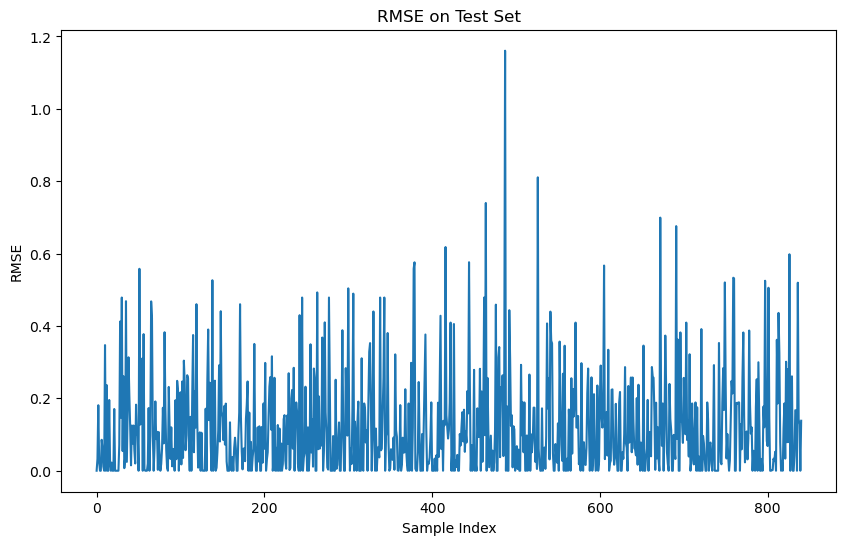

In [ ]:
# Calculating the RMSE for all the samples in test set and plot the RMSE values
yhat = []
RMSE = []
sum = 0

# Iterate through the test set using enumerate to get both index and value
for i, x_test in enumerate(X_test_dense):
    # Predict the value for the current test sample
    prediction = model.predict(x_test.reshape(1, -1))
    
    # Append the predicted value to the yhat list
    yhat.append(prediction[0])
    
    # Calculate d1 and d2
    d1 = (prediction[0] - scaled_labels_test_df.iloc[i, 0]).item()
    d2 = (prediction[0] - scaled_labels_test_df.iloc[i, 1]).item()
    
    # Calculate the loss (RMSE) and append it to the RMSE list
    if d1 >= 0:
        if d2 <= 0:
            loss = 0
        else:
            loss = (((d2**2)/1)**.5)
    else:
        loss = (((d1**2)/1)**.5)
    RMSE.append(loss)
    sum += loss
    
    print(f'RMSE(pred{i}, y{i}): {loss}')
rmse_m = sum / X_test_dense.shape[0]
print(f'Mean RMSE: {rmse_m}')

# Plotting the RMSE values
plt.figure(figsize=(10, 6))
plt.plot(RMSE)
plt.xlabel('Sample Index')
plt.ylabel('RMSE')
plt.title('RMSE on Test Set')
plt.show()

## End

In [17]:
print(f'Took {(time() - time_start) / 60:.2f} minutes!')

Took 1.20 minutes!
